# Test NEWT for WBGT calculation

In [1]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), cartopy

import numpy as np
import pandas as pd
import os, glob, re, sys
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import matplotlib.pyplot as plt
import netCDF4

%matplotlib inline

In [2]:
sys.path.append('../atmos/')
#import atmos
from atmos import thermo

In [297]:
from settings_ana import *
figdir = os.path.join(figdirs, 'fig_sep24')


In [132]:
# heat stress package from Schwingshackl, 2021
sys.path.append('../CDS_heat_stress_indicators/')
import calc_heat_stress_indicators as hsi

In [3]:
print(thermo.pseudo_wet_bulb_temperature.__doc__)
print(thermo.isobaric_wet_bulb_temperature.__doc__)


    Computes pseudo wet-bulb temperature.

    Pseudo wet-bulb temperature is the temperature of a parcel of air lifted
    adiabatically to saturation and then brought pseudoadiabatically at
    saturation back to its original pressure. It is always less than the
    isobaric wet-bulb temperature.

    See https://glossary.ametsoc.org/wiki/Wet-bulb_temperature.

    Args:
        p (float or ndarray): pressure (Pa)
        T (float or ndarray): temperature (K)
        q (float or ndarray): specific humidity (kg/kg)
        phase (str, optional): condensed water phase (valid options are
            'liquid', 'ice', or 'mixed'; default is 'liquid')
        polynomial (bool, optional): flag indicating whether to use polynomial
            fits to pseudoadiabats (default is True)

    Returns:
        Tw (float or ndarray): pseudo wet-bulb temperature (K)

    

    Computes isobaric wet-bulb temperature.

    Isobaric wet-bulb temperature is the temperature of a parcel of air cooled
   

In [4]:
print(thermo.wet_bulb_temperature.__doc__)



    Computes wet-bulb temperature for specified saturation process.

    Args:
        p (float or ndarray): pressure (Pa)
        T (float or ndarray): temperature (K)
        q (float or ndarray): specific humidity (kg/kg)
        saturation (str, optional): saturation process (valid options are
            'pseudo' or 'isobaric'; default is 'pseudo')
        phase (str, optional): condensed water phase (valid options are
            'liquid', 'ice', or 'mixed'; default is 'liquid')
        polynomial (bool, optional): flag indicating whether to use polynomial
            fits to pseudoadiabats (default is True)

    Returns:
        Tw: wet-bulb temperature (K)

    


In [79]:
print(thermo.relative_humidity.__doc__)



    Computes relative humidity with respect to specified phase from pressure, 
    temperature, and specific humidity.

    Args:
        p (float or ndarray): pressure (Pa)
        T (float or ndarray): temperature (K)
        q (float or ndarray): specific humidity (kg/kg)
        qt (float or ndarray, optional): total water mass fraction (kg/kg)
            (default is None, which implies qt = q)
        phase (str, optional): condensed water phase (valid options are
            'liquid', 'ice', or 'mixed'; default is 'liquid')
        omega (float or ndarray, optional): ice fraction at saturation 
            (default is 0.0)
        
    Returns:
        RH (float or ndarray): relative humidity (fraction)

    


# Test run Tw calculation (isobaric)

Not what I will use

In [163]:
thermo.wet_bulb_temperature(1030*100,30+273.15,.008, saturation ='isobaric') - 273.15

18.373963931812114

In [164]:
p = 1000 * 100 # Pascals
T = np.arange(20,50,0.5) + 273.15 # Kelvin
q = np.arange(0.001, 0.05, 0.001) 

len(T), len(q)

(60, 49)

In [165]:
T_arr = np.array([T]*len(q) ) 
T_arr

array([[293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65],
       [293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65],
       [293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65],
       ...,
       [293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65],
       [293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65],
       [293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65]])

In [166]:
q_arr = np.array([q]*len(T) ).T
q_arr

array([[0.001, 0.001, 0.001, ..., 0.001, 0.001, 0.001],
       [0.002, 0.002, 0.002, ..., 0.002, 0.002, 0.002],
       [0.003, 0.003, 0.003, ..., 0.003, 0.003, 0.003],
       ...,
       [0.047, 0.047, 0.047, ..., 0.047, 0.047, 0.047],
       [0.048, 0.048, 0.048, ..., 0.048, 0.048, 0.048],
       [0.049, 0.049, 0.049, ..., 0.049, 0.049, 0.049]])

In [167]:
RH_arr = thermo.relative_humidity(p, T_arr, q_arr)
RH_arr

array([[0.0687042 , 0.06661227, 0.06459171, ..., 0.01401418, 0.01366764,
        0.01333085],
       [0.13732496, 0.13314364, 0.12910496, ..., 0.02801134, 0.02731868,
        0.02664551],
       [0.20586243, 0.19959425, 0.19353991, ..., 0.04199152, 0.04095315,
        0.03994401],
       ...,
       [3.14129326, 3.04564588, 2.95326162, ..., 0.64075639, 0.62491171,
        0.60951307],
       [3.20623401, 3.10860929, 3.01431514, ..., 0.65400291, 0.63783067,
        0.62211369],
       [3.27109808, 3.17149835, 3.07529657, ..., 0.66723379, 0.65073437,
        0.63469942]])

In [168]:
print(q_arr.shape, T_arr.shape, RH_arr.shape)

(49, 60) (49, 60) (49, 60)


<a list of 9 text.Text objects>

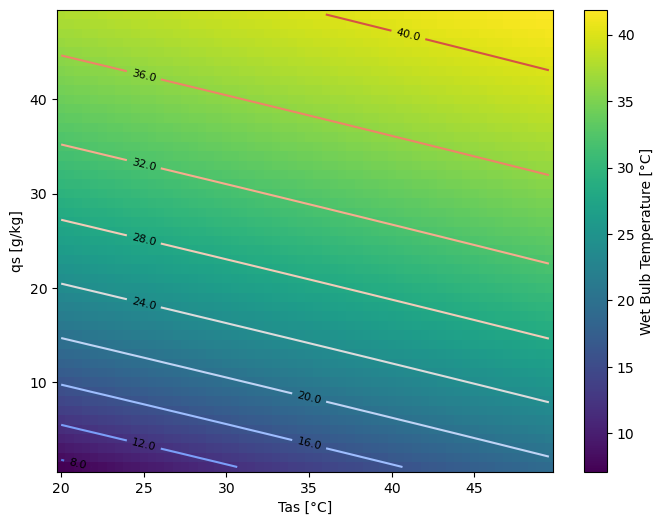

In [169]:
Tw_arr = thermo.wet_bulb_temperature(p,T_arr,q_arr, saturation ='isobaric') - 273.15

Tw_da = xr.DataArray(Tw_arr, coords=[ ('qs', q*1000), ('Tas', T-273.15)], name="Wet Bulb Temperature")
Tw_da.attrs['units'] = '°C'
Tw_da.coords['qs'].attrs['units'] = 'g/kg'  # Specific Humidity units
Tw_da.coords['Tas'].attrs['units'] = '°C'   # Temperature units

fig, ax = plt.subplots(figsize=(8, 6))


Tw_da.plot(ax =ax )
contours = ax.contour(Tw_da.Tas, Tw_da.qs, Tw_da.values, levels=10, cmap='coolwarm')
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f', colors='black')  # Adjust the format as needed


In [170]:
Tw_da_isobaric = Tw_da

In [171]:

WBGT_da = Tw_da*0.7 +Tw_da.Tas*0.3
WBGT_da.attrs['units'] = '°C'
WBGT_da.name='indoor WBGT'
WBGT_da

<xarray.DataArray 'indoor WBGT' (qs: 49, Tas: 60)>
array([[10.98004697, 11.3022496 , 11.62322882, ..., 27.72374161,
        27.9934836 , 28.26256355],
       [11.79490711, 12.11072504, 12.42538592, ..., 28.26532986,
        28.5316181 , 28.79728015],
       [12.58008005, 12.88983999, 13.19850701, ..., 28.79141525,
        29.05442054, 29.31683326],
       ...,
       [31.82937939, 32.03437095, 32.23923892, ..., 43.33602353,
        43.53499052, 43.73386787],
       [32.08987093, 32.29402526, 32.4980606 , ..., 43.55519728,
        43.7535401 , 43.95179628],
       [32.34629403, 32.54963659, 32.75286457, ..., 43.77146963,
        43.96920449, 44.16685556]])
Coordinates:
  * qs       (qs) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 45.0 46.0 47.0 48.0 49.0
  * Tas      (Tas) float64 20.0 20.5 21.0 21.5 22.0 ... 47.5 48.0 48.5 49.0 49.5
Attributes:
    units:    °C

<a list of 7 text.Text objects>

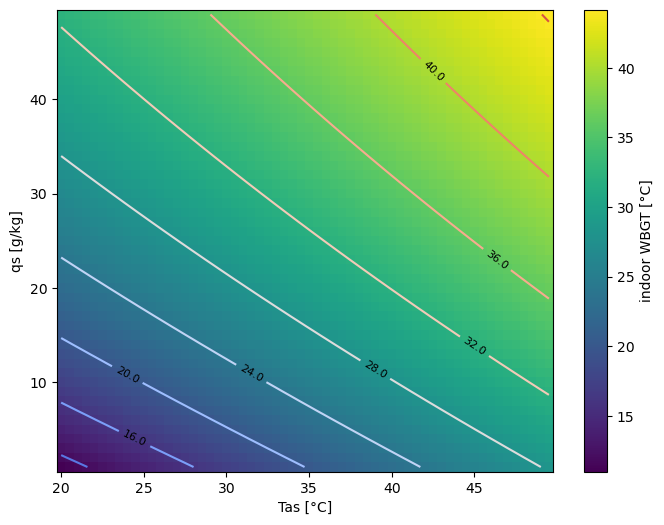

In [172]:

fig, ax = plt.subplots(figsize=(8, 6))


WBGT_da.plot(ax =ax )
contours = ax.contour(WBGT_da.Tas, WBGT_da.qs, WBGT_da.values, levels=10, cmap='coolwarm')
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f', colors='black')  # Adjust the format as needed


# Test run Tw calculation (pseudo-adiabatic)


In [173]:
thermo.wet_bulb_temperature(1030*100,30+273.15,.008, saturation ='pseudo') - 273.15

array([18.14564588])

In [174]:
p = 1000 * 100 # Pascals
T = np.arange(20,50,0.5) + 273.15 # Kelvin
q = np.arange(0.001, 0.05, 0.001) 

len(T), len(q)

(60, 49)

In [175]:
T_arr = np.array([T]*len(q) ) 
T_arr

array([[293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65],
       [293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65],
       [293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65],
       ...,
       [293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65],
       [293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65],
       [293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65]])

In [176]:
q_arr = np.array([q]*len(T) ).T
q_arr

array([[0.001, 0.001, 0.001, ..., 0.001, 0.001, 0.001],
       [0.002, 0.002, 0.002, ..., 0.002, 0.002, 0.002],
       [0.003, 0.003, 0.003, ..., 0.003, 0.003, 0.003],
       ...,
       [0.047, 0.047, 0.047, ..., 0.047, 0.047, 0.047],
       [0.048, 0.048, 0.048, ..., 0.048, 0.048, 0.048],
       [0.049, 0.049, 0.049, ..., 0.049, 0.049, 0.049]])

In [177]:
print(q_arr.shape, T_arr.shape)

(49, 60) (49, 60)


<a list of 9 text.Text objects>

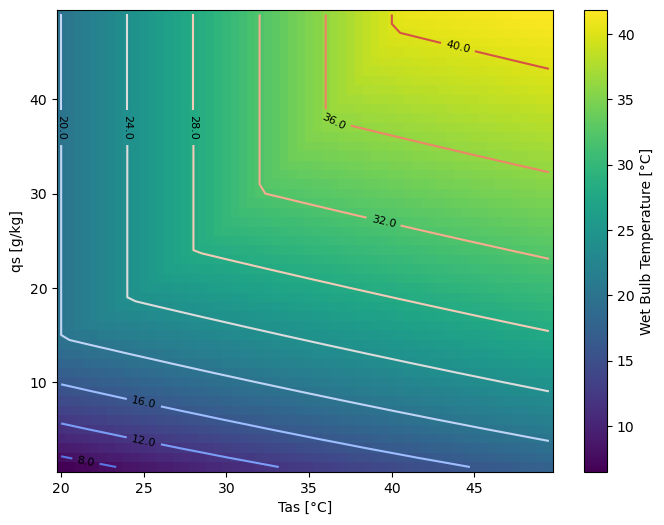

In [178]:
Tw_arr = thermo.wet_bulb_temperature(p,T_arr,q_arr, saturation ='pseudo') - 273.15

Tw_da = xr.DataArray(Tw_arr, coords=[ ('qs', q*1000), ('Tas', T-273.15)], name="Wet Bulb Temperature")
Tw_da.attrs['units'] = '°C'
Tw_da.coords['qs'].attrs['units'] = 'g/kg'  # Specific Humidity units
Tw_da.coords['Tas'].attrs['units'] = '°C'   # Temperature units

fig, ax = plt.subplots(figsize=(8, 6))


Tw_da.plot(ax =ax )
contours = ax.contour(Tw_da.Tas, Tw_da.qs, Tw_da.values, levels=10, cmap='coolwarm')
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f', colors='black')  # Adjust the format as needed


In [179]:
Tw_da_adiabatic = Tw_da

In [180]:

WBGT_da = Tw_da*0.7 +Tw_da.Tas*0.3
WBGT_da.attrs['units'] = '°C'
WBGT_da.name='indoor WBGT'
WBGT_da

<xarray.DataArray 'indoor WBGT' (qs: 49, Tas: 60)>
array([[10.54839711, 10.86001043, 11.17031155, ..., 26.56960496,
        26.82490193, 27.07948839],
       [11.47994266, 11.78615186, 12.09109034, ..., 27.25334344,
        27.50529693, 27.75657143],
       [12.34656573, 12.64759626, 12.94741485, ..., 27.89316865,
        28.14214432, 28.3904661 ],
       ...,
       [19.99985063, 20.49980628, 20.99975077, ..., 43.3166142 ,
        43.5132616 , 43.70970406],
       [19.99985063, 20.49980628, 20.99975077, ..., 43.53786603,
        43.73399918, 43.92992866],
       [19.99985063, 20.49980628, 20.99975077, ..., 43.7560457 ,
        43.95167797, 44.14710736]])
Coordinates:
  * qs       (qs) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 45.0 46.0 47.0 48.0 49.0
  * Tas      (Tas) float64 20.0 20.5 21.0 21.5 22.0 ... 47.5 48.0 48.5 49.0 49.5
Attributes:
    units:    °C

<a list of 8 text.Text objects>

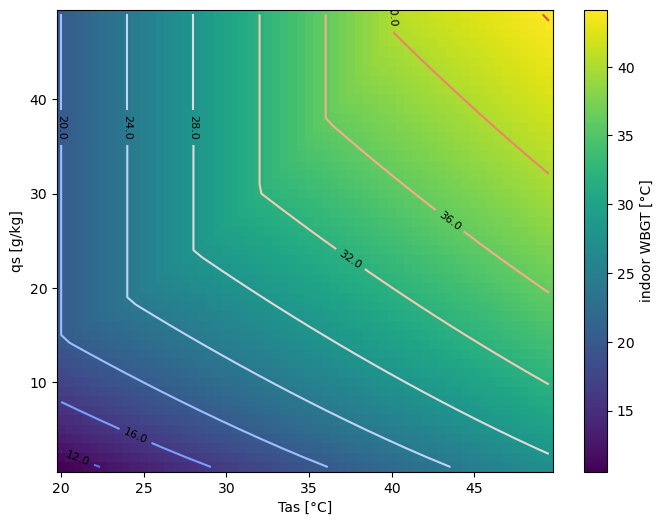

In [181]:

fig, ax = plt.subplots(figsize=(8, 6))


WBGT_da.plot(ax =ax )
contours = ax.contour(WBGT_da.Tas, WBGT_da.qs, WBGT_da.values, levels=10, cmap='coolwarm')
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f', colors='black')  # Adjust the format as needed


# save this fig and put in SI

# Test on a dataarray

In [182]:
# open da tasmax (small subregion) or make dummy dd

# open da qs (small subregion) or make dummy dd

# check / convert units 

# run NEWT on it or make wrapper fxn to do so 

# Test Tw from relative humidity

1. calculate specific humidity (q) from relative humidity (RH)
2. calc Tw from this

In [250]:
p = 1000 * 100 # Pascals
T = np.arange(-20,51,1) + 273.15 # Kelvin
RH = np.arange(0,101,1) # %

len(T), len(RH)

(71, 101)

In [251]:
T_arr = np.array([T]*len(RH) ) 
T_arr

array([[253.15, 254.15, 255.15, ..., 321.15, 322.15, 323.15],
       [253.15, 254.15, 255.15, ..., 321.15, 322.15, 323.15],
       [253.15, 254.15, 255.15, ..., 321.15, 322.15, 323.15],
       ...,
       [253.15, 254.15, 255.15, ..., 321.15, 322.15, 323.15],
       [253.15, 254.15, 255.15, ..., 321.15, 322.15, 323.15],
       [253.15, 254.15, 255.15, ..., 321.15, 322.15, 323.15]])

In [252]:
RH_arr = np.array([RH]*len(T) ).T
RH_arr

array([[  0,   0,   0, ...,   0,   0,   0],
       [  1,   1,   1, ...,   1,   1,   1],
       [  2,   2,   2, ...,   2,   2,   2],
       ...,
       [ 98,  98,  98, ...,  98,  98,  98],
       [ 99,  99,  99, ...,  99,  99,  99],
       [100, 100, 100, ..., 100, 100, 100]])

In [253]:
print(RH_arr.shape, T_arr.shape)

(101, 71) (101, 71)


In [254]:
es_arr = thermo.saturation_vapour_pressure(T_arr)
es_arr

# saturation vapor pressure (Pa)

array([[  125.70977236,   136.95326293,   149.09135854, ...,
        11182.65560553, 11757.96974892, 12358.48334748],
       [  125.70977236,   136.95326293,   149.09135854, ...,
        11182.65560553, 11757.96974892, 12358.48334748],
       [  125.70977236,   136.95326293,   149.09135854, ...,
        11182.65560553, 11757.96974892, 12358.48334748],
       ...,
       [  125.70977236,   136.95326293,   149.09135854, ...,
        11182.65560553, 11757.96974892, 12358.48334748],
       [  125.70977236,   136.95326293,   149.09135854, ...,
        11182.65560553, 11757.96974892, 12358.48334748],
       [  125.70977236,   136.95326293,   149.09135854, ...,
        11182.65560553, 11757.96974892, 12358.48334748]])

In [255]:
e_arr = RH_arr * (es_arr/100)
e_arr

# actual vapor pressure (Pa)

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.25709772e+00, 1.36953263e+00, 1.49091359e+00, ...,
        1.11826556e+02, 1.17579697e+02, 1.23584833e+02],
       [2.51419545e+00, 2.73906526e+00, 2.98182717e+00, ...,
        2.23653112e+02, 2.35159395e+02, 2.47169667e+02],
       ...,
       [1.23195577e+02, 1.34214198e+02, 1.46109531e+02, ...,
        1.09590025e+04, 1.15228104e+04, 1.21113137e+04],
       [1.24452675e+02, 1.35583730e+02, 1.47600445e+02, ...,
        1.10708290e+04, 1.16403901e+04, 1.22348985e+04],
       [1.25709772e+02, 1.36953263e+02, 1.49091359e+02, ...,
        1.11826556e+04, 1.17579697e+04, 1.23584833e+04]])

In [256]:
atmos.constant.eps

0.6218851570964247

In [257]:
# mixing ratio (kg/kg)

r_arr = (atmos.constant.eps * e_arr) / (p - e_arr)
r_arr

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.81780243e-06, 8.51703679e-06, 9.27190853e-06, ...,
        6.96211303e-04, 7.32071454e-04, 7.69506729e-04],
       [1.56358014e-05, 1.70343069e-05, 1.85440935e-05, ...,
        1.39398319e-03, 1.46586850e-03, 1.54092016e-03],
       ...,
       [7.67080016e-04, 8.35779909e-04, 9.09963031e-04, ...,
        7.65404834e-02, 8.09910979e-02, 8.56975627e-02],
       [7.74917116e-04, 8.44319855e-04, 9.19262094e-04, ...,
        7.74187389e-02, 8.19264119e-02, 8.66939325e-02],
       [7.82754414e-04, 8.52860034e-04, 9.28561434e-04, ...,
        7.82992059e-02, 8.28642184e-02, 8.76931123e-02]])

In [258]:
# correct for RH 100% divide by zero

#r_arr[0] = (atmos.constant.eps * es_arr[0]) / (p - es_arr[0])
#r_arr

In [259]:
# specific humidity (kg/kg)

qs_from_RH = r_arr / (1+r_arr)
qs_from_RH

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.81774131e-06, 8.51696425e-06, 9.27182256e-06, ...,
        6.95726930e-04, 7.31535917e-04, 7.68915044e-04],
       [1.56355569e-05, 1.70340167e-05, 1.85437497e-05, ...,
        1.39204271e-03, 1.46372288e-03, 1.53854938e-03],
       ...,
       [7.66492055e-04, 8.35081965e-04, 9.09135751e-04, ...,
        7.10985648e-02, 7.49230017e-02, 7.89331815e-02],
       [7.74317085e-04, 8.43607580e-04, 9.18417827e-04, ...,
        7.18557568e-02, 7.57227210e-02, 7.97776908e-02],
       [7.82142189e-04, 8.52133284e-04, 9.27700008e-04, ...,
        7.26136173e-02, 7.65231845e-02, 8.06230280e-02]])

In [260]:
qs_from_RH.shape

(101, 71)

In [261]:
Tw_arr = thermo.wet_bulb_temperature(p,T_arr,qs_from_RH, saturation ='pseudo') - 273.15
Tw_arr

array([[         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [-21.78980574, -20.92896595, -20.076309  , ...,  16.70325757,
         17.04563655,  17.38461557],
       [-21.76729026, -20.90464921, -20.05008919, ...,  17.41316308,
         17.78110448,  18.14635214],
       ...,
       [-20.03327078, -19.03553133, -18.03790925, ...,  47.64025721,
         48.63819127,  49.63366837],
       [-20.0163508 , -19.01731959, -18.01833346, ...,  47.82010787,
         48.82013614,  49.81628841],
       [-19.99943657, -18.99911484, -17.99876619, ...,  47.99874728,
         49.00070209,  49.99705349]])

<a list of 9 text.Text objects>

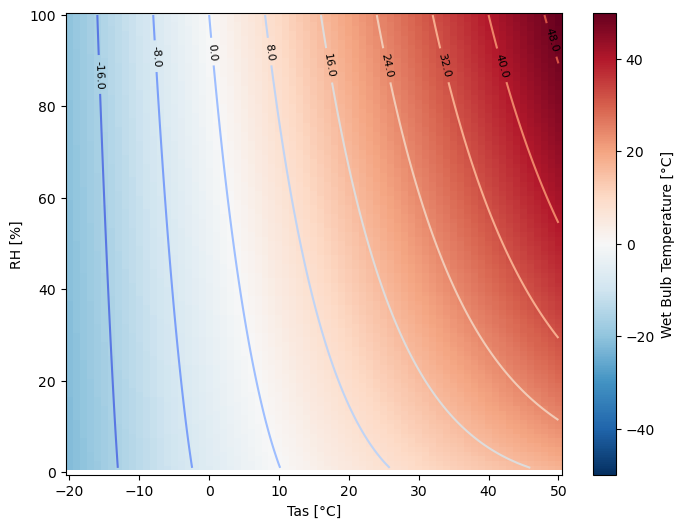

In [262]:
Tw_da = xr.DataArray(Tw_arr, coords=[ ('RH', RH), ('Tas', T-273.15)], name="Wet Bulb Temperature")
Tw_da.attrs['units'] = '°C'
Tw_da.coords['RH'].attrs['units'] = '%'  # Specific Humidity units
Tw_da.coords['Tas'].attrs['units'] = '°C'   # Temperature units

fig, ax = plt.subplots(figsize=(8, 6))


Tw_da.plot(ax =ax )
contours = ax.contour(Tw_da.Tas, Tw_da.RH, Tw_da.values, levels=10, cmap='coolwarm')
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f', colors='black') 

In [263]:
WBGT_da = Tw_da*0.7 +Tw_da.Tas*0.3
WBGT_da.attrs['units'] = '°C'
WBGT_da.name='indoor WBGT'
WBGT_da

<xarray.DataArray 'indoor WBGT' (RH: 101, Tas: 71)>
array([[         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [-21.25286402, -20.35027617, -19.4534163 , ...,  26.0922803 ,
         26.63194558,  27.1692309 ],
       [-21.23710318, -20.33325445, -19.43506243, ...,  26.58921416,
         27.14677313,  27.7024465 ],
       ...,
       [-20.02328955, -19.02487193, -18.02653647, ...,  47.74818005,
         48.74673389,  49.74356786],
       [-20.01144556, -19.01212371, -18.01283342, ...,  47.87407551,
         48.8740953 ,  49.87140189],
       [-19.9996056 , -18.99938039, -17.99913634, ...,  47.9991231 ,
         49.00049146,  49.99793744]])
Coordinates:
  * RH       (RH) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99 100
  * Tas      (Tas) float64 -20.0 -19.0 -18.0 -17.0 -16.0 ... 47.0 48.0 49.0 50.0
Attributes:
    units:    °C

<a list of 9 text.Text objects>

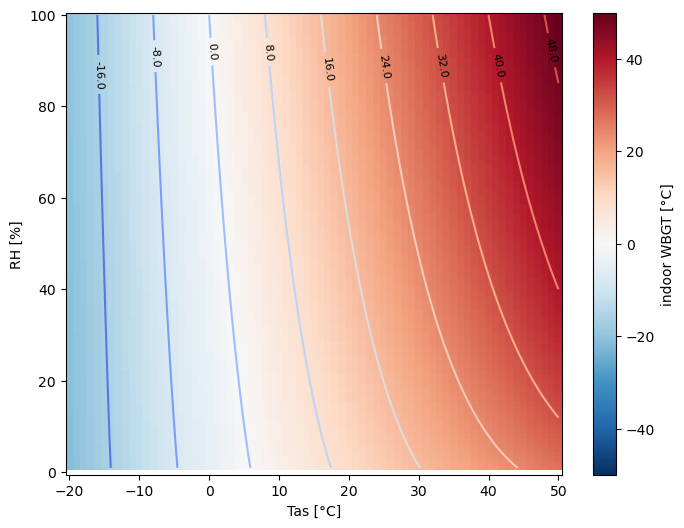

In [265]:

fig, ax = plt.subplots(figsize=(8, 6))

WBGT_da.plot(ax =ax )
contours = ax.contour(WBGT_da.Tas, WBGT_da.RH, WBGT_da.values, levels=10, cmap='coolwarm')
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f', colors='black')  # Adjust the format as needed


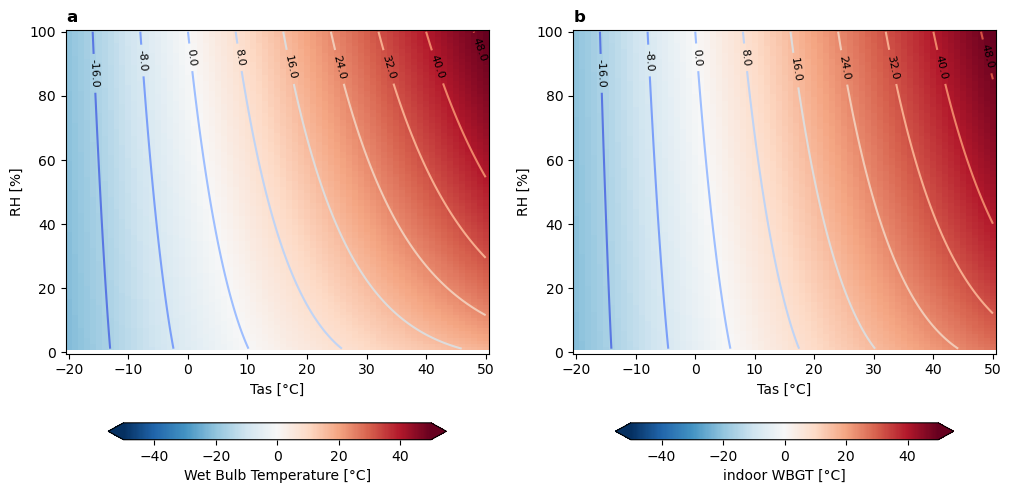

In [299]:
fig, axes = plt.subplots(1,2,figsize=(12, 6))

ax=axes[0]
Tw_da.plot(ax =ax, cbar_kwargs={"orientation": "horizontal", 'extend':'both', 'shrink':0.8} )
contours = ax.contour(Tw_da.Tas, Tw_da.RH, Tw_da.values, levels=10, cmap='coolwarm')
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f', colors='black')  
ax.set_title('a',loc='left',fontweight='bold')

ax=axes[1]
WBGT_da.plot(ax =ax, cbar_kwargs={"orientation": "horizontal", 'extend':'both', 'shrink':0.8} )
contours = ax.contour(WBGT_da.Tas, WBGT_da.RH, WBGT_da.values, levels=10, cmap='coolwarm')
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f', colors='black')  
ax.set_title('b',loc='left',fontweight='bold')



# plt.savefig(os.path.join(figdir, 'figSI_NEWT.png'), dpi=300, bbox_inches='tight', transparent=True)
# plt.savefig(os.path.join(figdir, 'figSI_NEWT.pdf'), dpi=300, bbox_inches='tight', transparent=True)

# Compare with HSI 

In [196]:
p = 1000 * 100 # Pascals
T = np.arange(20,50,0.5) + 273.15 # Kelvin
q = np.arange(0.001, 0.05, 0.001) # kg/kg

len(T), len(q)

(60, 49)

In [197]:
T_arr = xr.DataArray([T]*len(q) )
T_arr

<xarray.DataArray (dim_0: 49, dim_1: 60)>
array([[293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65],
       [293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65],
       [293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65],
       ...,
       [293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65],
       [293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65],
       [293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65]])
Dimensions without coordinates: dim_0, dim_1

In [198]:
q_arr = xr.DataArray(np.array([q]*len(T)).T )
q_arr

<xarray.DataArray (dim_0: 49, dim_1: 60)>
array([[0.001, 0.001, 0.001, ..., 0.001, 0.001, 0.001],
       [0.002, 0.002, 0.002, ..., 0.002, 0.002, 0.002],
       [0.003, 0.003, 0.003, ..., 0.003, 0.003, 0.003],
       ...,
       [0.047, 0.047, 0.047, ..., 0.047, 0.047, 0.047],
       [0.048, 0.048, 0.048, ..., 0.048, 0.048, 0.048],
       [0.049, 0.049, 0.049, ..., 0.049, 0.049, 0.049]])
Dimensions without coordinates: dim_0, dim_1

In [199]:
print(q_arr.shape, T_arr.shape)

(49, 60) (49, 60)


In [200]:
# calculate relative humidity from specific
e,RH = hsi.get_humidity(q_arr, p, T_arr) # kg/kg, Pa, K 


In [201]:
# wet bulb temperature
Tw_arr = hsi.WBT_DavJon(T_arr, RH, p)

In [202]:
# wet bulb globe temperature
WBGT = hsi.WBGT(T_arr, RH, p)

In [203]:
Tw_arr

<xarray.DataArray (dim_0: 49, dim_1: 60)>
array([[ 6.4768524,  6.708635 ,  6.938668 , ..., 17.335293 , 17.490362 ,
        17.644445 ],
       [ 7.8419404,  8.06715  ,  8.290678 , ..., 18.437986 , 18.590717 ,
        18.742558 ],
       [ 9.109458 ,  9.328544 ,  9.546012 , ..., 19.458847 , 19.609297 ,
        19.758938 ],
       ...,
       [20.094034 , 20.597794 , 21.100605 , ..., 39.294563 , 39.3614   ,
        39.42831  ],
       [20.094034 , 20.597794 , 21.100605 , ..., 39.479397 , 39.54483  ,
        39.610336 ],
       [20.094034 , 20.597794 , 21.100605 , ..., 39.65826  , 39.722317 ,
        39.78644  ]], dtype=float32)
Dimensions without coordinates: dim_0, dim_1

<a list of 8 text.Text objects>

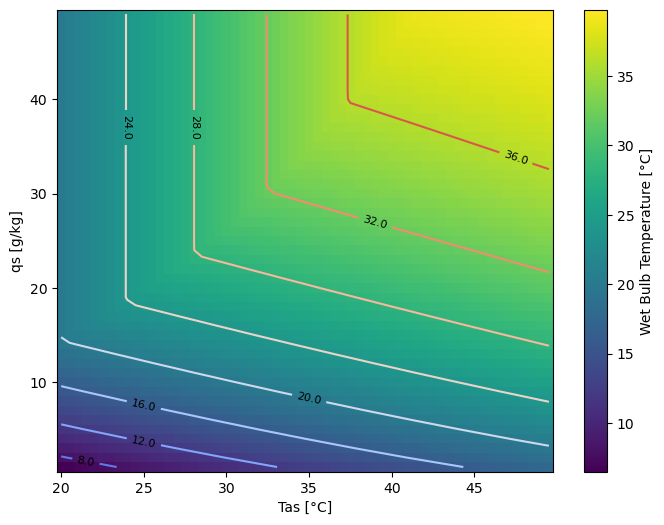

In [204]:

Tw_da = xr.DataArray(Tw_arr.data, coords=[ ('qs', q*1000), ('Tas', T-273.15)], name="Wet Bulb Temperature")
Tw_da.attrs['units'] = '°C'
Tw_da.coords['qs'].attrs['units'] = 'g/kg'  # Specific Humidity units
Tw_da.coords['Tas'].attrs['units'] = '°C'   # Temperature units

fig, ax = plt.subplots(figsize=(8, 6))


Tw_da.plot(ax =ax )
contours = ax.contour(Tw_da.Tas, Tw_da.qs, Tw_da.values, levels=10, cmap='coolwarm')
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f', colors='black')  # Adjust the format as needed


In [205]:
Tw_da_hsi = Tw_da

# Compare NEWT - HSI (Tw)

HSI is biased cold at high Tw values?? and some differences around the 100% RH line 

<a list of 9 text.Text objects>

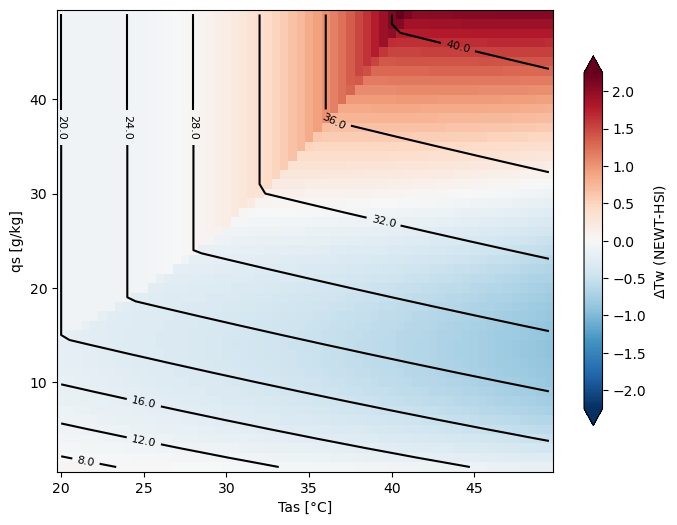

In [306]:
fig, ax = plt.subplots(figsize=(8, 6))

(Tw_da_adiabatic - Tw_da_hsi).plot( cbar_kwargs={"label": "$\Delta$Tw (NEWT-HSI)", 'extend':'both', 'shrink':0.8} ) # difference

contours = ax.contour(Tw_da_adiabatic.Tas, Tw_da_adiabatic.qs, Tw_da_adiabatic.values, levels=10, colors='k')
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f', colors='black') # WBGT values (NEWT)
